<a href="https://colab.research.google.com/github/pidipidi/cs577_RLI/blob/master/assignment_1/problem_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 3 - Real-world robot demonstrations using a Baxter robot

This notebook is an implementation of **Dynamic Movement Primitives (DMPs)** within a `robomimic` simulation environment. The implementation is built on top of the [robomimic tutorial](https://colab.research.google.com/drive/1b62r_km9pP40fKF0cBdpdTO2P_2eIbC6?usp=sharing).

## Environment Setup

In [1]:
WS_DIR = "/content/"
%cd $WS_DIR

# Clone the repo and install the basic requirements
!git clone --branch v0.4 https://github.com/ARISE-Initiative/robomimic
!pip install -e robomimic/ > /dev/null

import sys
import os
sys.path.append('./robomimic/')

/content
Cloning into 'robomimic'...
remote: Enumerating objects: 3546, done.
remote: Counting objects: 100% (1647/1647), done.
remote: Compressing objects: 100% (380/380), done.
remote: Total 3546 (delta 1437), reused 1267 (delta 1267), pack-reused 1899 (from 2)
Receiving objects: 100% (3546/3546), 62.07 MiB | 13.68 MiB/s, done.
Resolving deltas: 100% (2467/2467), done.


In [2]:
# install all system dependencies for mujoco-py
!sudo DEBIAN_FRONTEND=noninteractive apt install curl git libgl1-mesa-dev libgl1-mesa-glx libglew-dev \
         libosmesa6-dev software-properties-common net-tools unzip vim \
         virtualenv wget xpra xserver-xorg-dev libglfw3-dev patchelf > /dev/null

#install mujoco-py
!pip install mujoco==3.3.0 > /dev/null

#install robosuite
!pip install robosuite > /dev/null



Extracting templates from packages: 100%


In [3]:
import mujoco

mujoco.__version__

'3.3.0'

In [4]:
# import all utility functions

import os
import json
import h5py
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import robomimic
import robomimic.utils.obs_utils as ObsUtils
import robomimic.utils.torch_utils as TorchUtils
import robomimic.utils.test_utils as TestUtils
import robomimic.utils.file_utils as FileUtils
import robomimic.utils.train_utils as TrainUtils
from robomimic.utils.dataset import SequenceDataset

from robomimic.config import config_factory
from robomimic.algo import algo_factory

# for rendering mujoco in colab, you need turn on egl
os.environ['MUJOCO_GL'] = 'osmesa' # if gpu possible, use 'egl', if not, use 'osmesa'

# the dataset registry can be found at robomimic/__init__.py
from robomimic import DATASET_REGISTRY, HF_REPO_ID

# set download folder and make it
download_folder = WS_DIR + "robomimic_data/"
os.makedirs(download_folder, exist_ok=True)

# download the dataset
task = "lift"
dataset_type = "ph"
hdf5_type = "low_dim"
FileUtils.download_file_from_hf(
    repo_id=HF_REPO_ID,
    filename=DATASET_REGISTRY[task][dataset_type][hdf5_type]["url"],
    download_dir=download_folder,
)

# enforce that the dataset exists
dataset_path = os.path.join(download_folder, "low_dim_v15.hdf5")
assert os.path.exists(dataset_path)

ROBOMIMIC WARNING(
    No private macro file found!
    It is recommended to use a private macro file
    To setup, run: python /content/robomimic/robomimic/scripts/setup_macros.py
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


low_dim_v15.hdf5:   0%|          | 0.00/21.1M [00:00<?, ?B/s]

In [5]:
!pip install pydmps > /dev/null

In [8]:
import robomimic.utils.env_utils as EnvUtils
from robosuite import load_composite_controller_config
from robosuite.environments.robot_env import RobotEnv
from robosuite.models.tasks import Task
from robosuite.models.arenas.empty_arena import EmptyArena

class Free(RobotEnv):
    def __init__(self, robots, controller_configs):
        super().__init__(robots=robots, controller_configs=controller_configs)

    @property
    def _visualizations(self):
        """
        Visualization keywords for this environment

        Returns:
            set: All components that can be individually visualized for this environment
        """
        vis_set = super()._visualizations
        vis_set.add("grippers")
        return vis_set

    def reward(self, action):
        return 0

    def _load_model(self):
        super()._load_model()

        self.robots[0].robot_model.set_base_xpos([-1, 0, 0])

        mujoco_arena = EmptyArena()
        mujoco_arena.set_origin([0, 0, 0])

        self.model = Task(
            mujoco_arena = mujoco_arena,
            mujoco_robots = [robot.robot_model for robot in self.robots],
        )

    def _check_robot_configuration(self, robots):
        pass

config = load_composite_controller_config(controller="WHOLE_BODY_IK")

env = Free(robots=["Baxter"], controller_configs=config)

[robosuite WARNING] No private macro file found! (macros.py:53)
[robosuite WARNING] It is recommended to use a private macro file (macros.py:54)
[robosuite WARNING] To setup, run: python /usr/local/lib/python3.12/dist-packages/robosuite/scripts/setup_macros.py (macros.py:55)
[robosuite WARNING] Could not import robosuite_models. Some robots may not be available. If you want to use these robots, please install robosuite_models from source (https://github.com/ARISE-Initiative/robosuite_models) or through pip install. (__init__.py:30)
[robosuite WARNING] Could not load the mink-based whole-body IK. Make sure you install related import properly, otherwise you will not be able to use the default IK controller setting for GR1 robot. (__init__.py:40)
[robosuite INFO] Loading controller configuration from: /usr/local/lib/python3.12/dist-packages/robosuite/controllers/config/default/composite/whole_body_ik.json (composite_controller_factory.py:121)
INFO:robosuite_logs:Loading controller configu

### Download Demonstration Dataset

We download a pouring motion demo from the MIME dataset. (you can download other demo. if you want.)

In [19]:
def extract_data():
    """
    Extract a pouring motion demo from the MIME dataset. (you can download other demo. if you want.)
    """
    cur_dir = os.getcwd().split('/')[-1]
    assert cur_dir=='content', "Run the program on the assignment_1 folder. Current directory is {}".format(cur_dir)

    if os.path.isdir('dataset') is False:
        os.mkdir('dataset')
    os.chdir( 'dataset' )

    url = 'https://www.dropbox.com/sh/wmyek0jhrpm0hmh/AADAO2L1qN5BwOBthyMG82ima/4315Aug02?dl=0.zip'
    if os.path.isfile(url.split('/')[-1]) is False:
        os.system('wget '+url)

    if os.path.isfile('joint_angles.txt') is False:
        os.system('unzip 4315Aug02?dl=0.zip')

    print (os.getcwd())

    data = []
    for line in open('joint_angles.txt', 'r'):
        data.append( json.loads(line))

    # Get left/right arm trajectories
    joint_names = ['s0', 's1', 'e0', 'e1', 'w0', 'w1', 'w2']

    l_arm_traj = []
    r_arm_traj = []
    for d in data:
        v = []
        for name in joint_names:
            v.append(d['left_'+name])
        l_arm_traj.append(v)

        v = []
        for name in joint_names:
            v.append(d['right_'+name])
        r_arm_traj.append(v)

    os.chdir( '..' )
    return np.swapaxes(r_arm_traj, 0, 1)

In [11]:
def fk_request(fk_solver, joint_angle):
    '''
    Forward kinematics that returns a desired pose

    fk_solver object: forward kinematics from KDL.
    joint_angle list/array: a list of joint target joint angles
    '''
    homo_mat = fk_solver.forward(joint_angle)
    pos, quat = PoseConv.to_pos_quat(homo_mat)
    return pos, quat


def ik_request(ik_solver, poses, seed_angle):
    '''
    Inverse kinematics that returns a sequence of desired joint angles

    ik_solver object: inverse kinematics from TRAC_IK.
    poses Pose: a sequence of target poses
    seed_angle list/array: reference angles (for nullspace control)
    '''

    if type(poses) is not list:
        poses = [poses]

    joint_positions = []
    for i, ps in enumerate(poses):
        if i%10==0: print (i, len(poses))
        ret = ik_solver.get_ik(seed_angle,
                                   ps.position.x,
                                   ps.position.y,
                                   ps.position.z,
                                   ps.orientation.x,
                                   ps.orientation.y,
                                   ps.orientation.z,
                                   ps.orientation.w,
                                   bx=1e-4, by=1e-4, bz=1e-4,
                                   brx=1e-4, bry=1e-4, brz=1e-4)


        if ret is None:
            continue
        seed_angle = ret
        ##       rospy.logerr("INVALID POSE - No Valid Joint Solution Found in {}th pose.".format(i))
        ##       return False

        joint_positions.append(ret)

    return np.swapaxes(joint_positions, 0,1)



def plot_traj(trajs, trajs_demo=None):
    """
    """

    fig = plt.figure()

    for i, traj in enumerate(trajs):
        fig.add_subplot(len(trajs), 1, i+1)
        plt.plot(traj, label=str(i))

        if trajs_demo is not None:
            plt.plot(trajs_demo[0][i], 'r-', label=str(i))

    plt.show()

## A. Train improved DMPs using a joint-space demonstration.

In this problem, we will re-use the improved Dynamic Movement Primitives (DMPs) to learn and reproduce a robot demonstration trajectory.

### Improved DMP Formulation

Now, let’s formulate the original DMP equations:

- **Canonical System:**  
  <div align="center">
  $
  \tau \dot{s} = -\alpha s
  $
  </div>

- **Nonlinear Function:**  
  <div align="center">
  $
  f(s) = \frac{\sum_i w_i \, \phi_i(s)\, s}{\sum_i \phi_i(s)}
  $
  </div>  

- **Transformation System:**  
  <div align="center">
  $
  \tau \dot{v} = K(g - x) - Dv + K(g - x_0)s + Kf, \quad \tau \dot{x} = v
  $
  </div>
  
Based on these equations, please complete the code blocks below to implement the original DMP formulation. Note that you can copy the code for the original DMP's transformation system and DMP class code.

In [12]:
class OriginalFormulation(object):

    def __init__(self, K=50., D=None):
        self.K = K
        if D is None:
            D = 2.0 * np.sqrt(self.K)
        self.D = D

    def acceleration(self, x, dx, start, goal, tau, f, s):
        ''' return acceleration '''
        #------------------------------------------------------------
        # Place your code here
        return (self.K*(goal-x) - self.D*dx + (goal-start)*f) / tau
        #------------------------------------------------------------

    def fs(self, x, dx, ddx, start, goal, tau, s):
        ''' return nonlinear function value '''
        #------------------------------------------------------------
        # Place your code here
        return (tau*ddx - self.K*(goal-x) + self.D*dx) / (goal-start)
        #------------------------------------------------------------

class ImprovedFormulation(object):

    def __init__(self, K=50., D=None):
        self.K = K
        if D is None:
            D = self.K/4.
        self.D = D

    def acceleration(self, x, dx, start, goal, tau, f, s):
        ''' return acceleration '''
        #------------------------------------------------------------
        # Place your code here
        return (self.K*(goal-x) - self.D*dx - self.K*(goal-start)*s + self.K*f) / tau
        #------------------------------------------------------------

    def fs(self, x, dx, ddx, start, goal, tau, s):
        ''' return nonlinear function value '''
        #------------------------------------------------------------
        # Place your code here
        return ((tau**2*ddx + self.D*dx*tau) / self.K) - (goal-x) + (goal-start)*s
        #------------------------------------------------------------

In [13]:
class DMPs_discrete(object):

    def __init__(self, dims, bfs, dt=.01, tau=1., alpha=14, enable_improved=False, **kwargs):
        '''
        dims int: number of dynamic motor primitives
        bfs int: number of basis functions per DMP
        dt float: timestep for simulation
        tau float: scales the timestep
                   increase tau to make the system execute faster
        alpha float: canonical system parameter
        '''

        self.dmps = dims
        self.bfs  = bfs
        self.dt   = dt
        self.tau  = tau
        self.alpha = alpha/2.0
        self.alpha_x = alpha

        self.prep_centers_and_variances()

        if enable_improved is False:
            self.formulation = OriginalFormulation()
        else:
            self.formulation = ImprovedFormulation()

        return


    def prep_centers_and_variances(self):
        '''
        Set the centre of the Gaussian basis functions be spaced evenly
        throughout run time.
        '''
        self.c = np.zeros(self.bfs)
        self.h = np.zeros(self.bfs)

        t = np.linspace(0,1,self.bfs) *0.5

        # From DMP matlab code
        self.c = np.exp(-self.alpha_x*t)
        self.D = (np.diff(self.c)*0.55)**2
        self.D = np.append(self.D, self.D[-1])
        self.D = 1/self.D
        self.h = np.ones(self.bfs)*0.5


    def gen_psi(self, x):
        '''
        Generates the activity of the basis functions for a given state of the
        canonical system.

        x float: the current state of the canonical system
        '''
        if isinstance(x, np.ndarray):
            x = x[:,None]
        return np.exp(-self.h * (x - self.c)**2 * self.D)


    def gen_phase(self, n_steps, tau=None):
        """
        Generate phase for open loop movements.

        n_steps int: number of steps
        """
        if tau is None: tau = self.tau
        return np.exp(-self.alpha/tau * np.linspace(0, 1, n_steps))


    def learn(self, y_des):
        """
        Encode a set of weights from the input trajectories.

        y_des list/array: the desired trajectories of each DMP
                          should be shaped [dmps, run_time]
        """
        # Set variables
        n_samples, dims, n_steps = np.shape(y_des)
        self.n_steps = n_steps
        assert dims==self.dmps, "wrong dimensions"

        # Get start and goal
        self.y0   = np.mean(y_des[:,:,0], axis=0)
        self.goal = np.mean(y_des[:,:,-1], axis=0)

        # Calculate yd_des, ydd_des
        yd_des = np.diff(y_des) / self.dt
        yd_des = np.concatenate((np.zeros((n_samples, self.dmps, 1)), yd_des), axis=2)

        ydd_des = np.diff(yd_des) / self.dt
        ydd_des = np.concatenate((np.zeros((n_samples, self.dmps, 1)), ydd_des), axis=2)

        # Get a canonical system
        x_track = self.gen_phase(n_steps)

        #------------------------------------------------------------
        # Place your code here

        # Calculate f
        f_des = np.zeros((n_samples, self.dmps, n_steps))
        for i in range(n_samples):
            for j in range(self.dmps):
                f_des[i,j] = self.formulation.fs(y_des[i,j], yd_des[i,j], ydd_des[i,j],
                                                     self.y0[j:j+1], self.goal[j:j+1], self.tau,
                                                     x_track)

        # Calculate weights
        psi_track = self.gen_psi(x_track)

        x_track   = np.tile(x_track, n_samples)
        psi_track = np.tile(psi_track, (n_samples,1))
        f_des     = np.swapaxes(f_des, 0, 1)
        f_des     = f_des.reshape((self.dmps,n_samples*n_steps))

        self.w = np.zeros((self.dmps, self.bfs))
        for d in range(self.dmps):
            for b in range(self.bfs):
                numer = np.sum(x_track    * psi_track[:,b] * f_des[d,:])
                denom = np.sum(x_track**2 * psi_track[:,b]) + 1e-10
                self.w[d,b] = numer / denom
        #------------------------------------------------------------

        # set up tracking vectors
        y_track   = np.zeros((self.dmps, n_steps))
        yd_track  = np.zeros((self.dmps, n_steps))
        ydd_track = np.zeros((self.dmps, n_steps))

        y   = self.y0.copy()
        yd  = np.zeros(self.dmps)
        ydd = np.zeros(self.dmps)

        #------------------------------------------------------------
        # Place your code here
        x_track   = self.gen_phase(n_steps)
        psi_track = self.gen_psi(x_track)

        f = np.zeros((self.dmps,n_steps))
        for idx in range(self.dmps):
            f[idx] = np.sum(np.expand_dims(x_track,axis=1)*np.expand_dims(self.w[idx],axis=0)*psi_track, axis=1)/ np.sum(psi_track, axis=1)

        # Recover the demonstration using the learned weights (for confirmation)
        for t in range(n_steps):
            for idx in range(self.dmps):
                # Calcualte acceleration based on f(s)
                ydd[idx] = self.formulation.acceleration(y[idx], yd[idx], self.y0[idx],
                                                             self.goal[idx], self.tau,
                                                            f[idx,t], x_track[t])
                yd[idx] += ydd[idx] * self.dt * self.tau
                y[idx]  += yd[idx] * self.dt

            # record timestep
            y_track[:,t] = y
            yd_track[:,t] = yd
            ydd_track[:,t] = ydd
        #------------------------------------------------------------

        return y_track, yd_track, ydd_track


    def plan(self, y0=None, goal=None, **kwargs):
        '''
        Run the DMP system within a specific period.

        y0   list/array: start position
        goal list/array: goal position
        tau  float:      scales the timestep
                         increase tau to make the system execute faster
        '''

        if y0 is None: y0 = self.y0
        if goal is None: goal = self.goal
        n_steps = int(self.n_steps/self.tau)

        # set up tracking vectors
        y_track   = np.zeros((self.dmps, n_steps))
        yd_track  = np.zeros((self.dmps, n_steps))
        ydd_track = np.zeros((self.dmps, n_steps))
        x_track   = self.gen_phase(n_steps, self.tau)

        #------------------------------------------------------------
        # Place your code here
        y   = y0.copy()
        yd  = np.zeros(self.dmps)
        ydd = np.zeros(self.dmps)

        for t in range(n_steps):
            for idx in range(self.dmps):
                # Calcualte acceleration based on f(s)
                psi = self.gen_psi(x_track[t])
                f   = x_track[t] * ((np.dot(psi, self.w[idx])) / np.sum(psi))

                ydd[idx] = self.formulation.acceleration(y[idx], yd[idx], y0[idx], goal[idx], self.tau,
                                                        f, x_track[t])
                yd[idx] += ydd[idx] * self.tau * self.dt
                y[idx]  += yd[idx] * self.dt

            # record timestep
            y_track[:,t] = y
            yd_track[:,t] = yd
            ydd_track[:,t] = ydd
        #------------------------------------------------------------

        return y_track, yd_track, ydd_track


    def plot_traj(self, trajs_demo, trajs_gen, axis_num=0):
        """Plot trajectories over an axis """

        fig = plt.figure()
        plt.title('Trajectory (X) - Demo (Td) and generated (Tg)')
        for i in range(len(trajs_demo)):
            plt.plot(trajs_demo[i,axis_num,:], 'r--', label='Td')
        for i in range(len(trajs_gen)):
            plt.plot(trajs_gen[i,axis_num,:],'g-', label='Tg')

        plt.legend()
        plt.show()

    def plot_basis(self):
        """Plot basis functions """
        fig = plt.figure()

        x = self.gen_phase(200)

        for idx in range(len(self.c)):
            psi = self.gen_psi(x)
            plt.plot(x, psi)

        plt.show()

    def plot_f(self, f, f_des=None):
        """Plot nonlinear functions """

        fig = plt.figure()
        plt.plot(f)
        if f_des is not None:
            plt.plot(f_des, '--')
        plt.show()

    def plot_canonical_sys(self):
        """Plot the phase change in the canonical system """
        x = self.gen_phase(200)

        fig = plt.figure()
        plt.plot(x)
        plt.show()

### Reproduction of the robot demonstration

We train the improved DMPs with the selected robot-demonstration trajectory. Please, plot the reproduced trajectories with the demonstrated trajectory.

/content/dataset


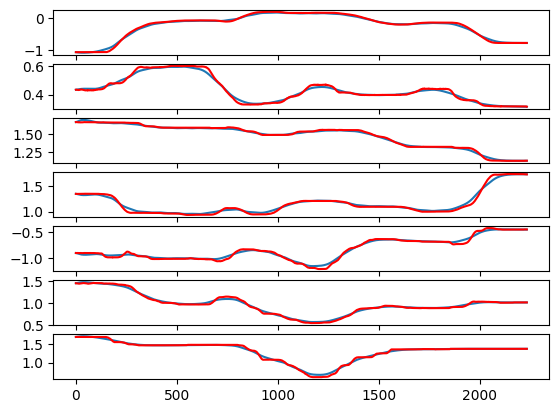

array([[-1.07855408, -1.07885964, -1.07928212, ..., -0.78680593,
        -0.7868201 , -0.78683376],
       [ 0.43455677,  0.43466149,  0.43480641, ...,  0.31514643,
         0.31511417,  0.31508258],
       [ 1.67271474,  1.67325396,  1.67399961, ...,  1.12524109,
         1.12524714,  1.1252532 ],
       ...,
       [-0.90685822, -0.90736793, -0.9080745 , ..., -0.45294016,
        -0.45293831, -0.45293625],
       [ 1.45827806,  1.45870124,  1.45928639, ...,  1.01588051,
         1.01589741,  1.01591412],
       [ 1.68372439,  1.68405752,  1.68451828, ...,  1.36775578,
         1.3677646 ,  1.36777322]])

In [20]:
def problem_3a1(enable_plot=True):
    traj = extract_data()

    dims      = len(traj)
    bfs       = 30
    tau       = 1.
    freq      = 100
    duration  = 1.
    dt        = 1./freq

    traj_demo = np.expand_dims(traj, axis=0)

    # Learn via DMP original/improved
    dmp = DMPs_discrete(dims=dims, bfs=bfs, tau=tau, dt=dt,
                            enable_improved=True)
    traj, _, _ = dmp.learn(traj_demo)
    traj, _, _ = dmp.plan()

    if enable_plot: plot_traj(traj, traj_demo)
    return traj

problem_3a1()

###  Reproduction with a Baxter robot

In [23]:
r_traj_data = problem_3a1(enable_plot=False)

/content/dataset


In [24]:
print(np.shape(r_traj_data))

(7, 2234)


In [26]:
import imageio
from copy import deepcopy
import numpy as np
import os

os.environ["MUJOCO_GL"] = 'osmesa'

# create a video writer
video_path = "rollout.mp4"
video_writer = imageio.get_writer(video_path, fps=20)

ob_dict = env.reset()
cur_joint_pos = ob_dict["robot0_joint_pos"]
#for i in range(len(r_traj_data[0])):
for i in range(100):
    positions = cur_joint_pos

    env.step(positions)

    frame = env.sim.render(height=512, width=512, camera_name="frontview")[::-1]
    video_writer.append_data(frame)

video_writer.close()

[robosuite WARNING] The config has defined for the controller "torso", but the robot does not have this component. Skipping, but make sure this is intended.Removing the controller config for torso from self.part_controller_config. (robot.py:151)
[robosuite WARNING] The config has defined for the controller "head", but the robot does not have this component. Skipping, but make sure this is intended.Removing the controller config for head from self.part_controller_config. (robot.py:151)
[robosuite WARNING] The config has defined for the controller "base", but the robot does not have this component. Skipping, but make sure this is intended.Removing the controller config for base from self.part_controller_config. (robot.py:151)
[robosuite WARNING] The config has defined for the controller "legs", but the robot does not have this component. Skipping, but make sure this is intended.Removing the controller config for legs from self.part_controller_config. (robot.py:151)


In [27]:
# visualize rollout video

from IPython.display import HTML
from base64 import b64encode

mp4 = open(video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=400 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")